# __CNN__

We decide to use CNN(convolutional neural networks) for the task of guitar tablature estimation. The previous work of Andrew Wiggins and Youngmoo Kim showed that CNNs have shown promise for translating guitar audios to tabs, and the use of CNNs has also been explored for various other tasks within music information retrieval such as musical tempo estimation, key classification, singing voice detection, and instrument classification. It is proven that CNN is a powerful tool for the purpose of our study.

## __Import libraries__

In [1]:
# Import required packages 
#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

#various
import datetime
import pathlib
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

#keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K


#sklearn
from sklearn.model_selection import train_test_split


# Load the TensorBoard notebook extension
%load_ext tensorboard

RSEED = 42

In [2]:
#Clear any logs from previous runs
!rm -rf ./logs/

In [3]:
# Check for Tensorflow version
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

2.8.0


## __"Write Python Script" function__

`%%write_and_run image_modeling.py` is the call of the register cell magic from below in 'w' mode (default). It writes the imports at the beginning of the `image_modeling.py`.

In [4]:
'''# Let's make some dark cell magic. Why not!

from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
        print("Appended to file ", file)
    else:
        print('Written to file:', file)
    with open(file, mode) as f:
        f.write(cell.format(**globals()))        
    get_ipython().run_cell(cell)'''

'# Let\'s make some dark cell magic. Why not!\n\nfrom IPython.core.magic import register_cell_magic\n\n@register_cell_magic\ndef write_and_run(line, cell):\n    argz = line.split()\n    file = argz[-1]\n    mode = \'w\'\n    if len(argz) == 2 and argz[0] == \'-a\':\n        mode = \'a\'\n        print("Appended to file ", file)\n    else:\n        print(\'Written to file:\', file)\n    with open(file, mode) as f:\n        f.write(cell.format(**globals()))        \n    get_ipython().run_cell(cell)'

## __Define Input Shapes__

In [5]:
#Import variables from our file
FRAME_HEIGHT = 192
FRAME_WIDTH = 9
N_CLASSES = 21
N_STRINGS = 6
BATCH_SIZE = 128
EPOCHS = 8

TRAIN_PATH = 'our trainset path.csv'
EVAL_PATH = 'our evalset path.csv'
TEST_PATH = 'our testset path.csv'

#TRAINING_SIZE = !wc -l < flowers_train.csv
#TRAINING_STEPS = int(TRAINING_SIZE[0]) // BATCH_SIZE




Using Tensorboard to monitor our results:

In [6]:
%tensorboard --logdir logs/fit

## __Load Data__

In [7]:
OUTPUT_PATH = "../data/output/"
audio_file = "02_BN1-129-Eb_solo_hex_cln.wav"

X = np.load(OUTPUT_PATH+'/'+audio_file.split('.')[0]+'_data.npz')
y = np.load(OUTPUT_PATH+'/'+audio_file.split('.')[0]+'_labels.npz')

In [8]:
X['arr_0']

array([[[  0.        ,   0.        ,   0.        , ..., -44.34732056,
         -44.10077667, -43.91782379],
        [  0.        ,   0.        ,   0.        , ..., -48.74607849,
         -49.20463562, -49.76281738],
        [  0.        ,   0.        ,   0.        , ..., -48.10150909,
         -48.1938858 , -48.34008789],
        ...,
        [  0.        ,   0.        ,   0.        , ..., -80.        ,
         -80.        , -80.        ],
        [  0.        ,   0.        ,   0.        , ..., -80.        ,
         -80.        , -80.        ],
        [  0.        ,   0.        ,   0.        , ..., -80.        ,
         -80.        , -80.        ]],

       [[  0.        ,   0.        ,   0.        , ..., -44.10077667,
         -43.91782379, -43.80202484],
        [  0.        ,   0.        ,   0.        , ..., -49.20463562,
         -49.76281738, -50.40135193],
        [  0.        ,   0.        ,   0.        , ..., -48.1938858 ,
         -48.34008789, -48.52977753],
        ...,


In [9]:
y['arr_0']

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
    

## __Do train & test split__

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X['arr_0'], y['arr_0'], test_size= 0.3, random_state= RSEED )

Do this again and split the train set, so we can produce a validation set

In [11]:

x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train, test_size = 0.1,random_state = RSEED)

In [12]:
print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)


(605, 192, 9)
(289, 192, 9)
(68, 192, 9)
(605, 6, 21)
(289, 6, 21)
(68, 6, 21)


## __Reshape__

Now we shall build the CNN!

Actually, no.

We'll have to do one final step of reshaping ALL the data before we go forward to build it.

Why do we need to reshape the data? Because each data point is in the form of a single row. In this CNN example, we're going to work with IMAGES.

The CNN needs images to extract coarse and fine features so that it can train and classify them.

In [13]:
im_shape = (FRAME_HEIGHT, FRAME_WIDTH, 1)
x_train = x_train.reshape(x_train.shape[0], *im_shape) # Python TIP :the * operator unpacks the tuple
x_test = x_test.reshape(x_test.shape[0], *im_shape)

In [14]:
x_train.shape

(605, 192, 9, 1)

## __Define functions__

In [15]:
#defining softmax function

def softmax_by_string(t):
        sh = K.shape(t)
        string_sm = []
        for i in range(N_STRINGS):
            string_sm.append(K.expand_dims(K.softmax(t[:,i,:]), axis=1))
        return K.concatenate(string_sm, axis=1)

In [16]:
'''def catcross_by_string(target, output):
        loss = 0
        for i in range(N_STRINGS):
            loss += K.categorical_crossentropy(target[:,i,:], output[:,i,:])
        return loss'''

'def catcross_by_string(target, output):\n        loss = 0\n        for i in range(N_STRINGS):\n            loss += K.categorical_crossentropy(target[:,i,:], output[:,i,:])\n        return loss'

## Building our CNN Model

In [17]:
def cnn_swizzle_model():       
        swizzle_model = tf.keras.Sequential()
        swizzle_model.add(tf.keras.layers.InputLayer(input_shape=[FRAME_HEIGHT, FRAME_WIDTH, 1]))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),activation='relu'))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        swizzle_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        swizzle_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        swizzle_model.add(tf.keras.layers.Dropout(0.25))   
        swizzle_model.add(tf.keras.layers.Flatten())
        swizzle_model.add(tf.keras.layers.Dense(128, activation='relu'))
        swizzle_model.add(tf.keras.layers.Dropout(0.5))
        swizzle_model.add(tf.keras.layers.Dense(126, activation='relu'))
        swizzle_model.add(tf.keras.layers.Dense(N_CLASSES * N_STRINGS)) # no activation
        swizzle_model.add(tf.keras.layers.Reshape((N_STRINGS, N_CLASSES)))
        swizzle_model.add(tf.keras.layers.Activation('softmax'))
        return swizzle_model

## Define model metrics for the cnn

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) 
#adadelta

In [19]:
swizzle_model = cnn_swizzle_model()
swizzle_model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 7, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 188, 5, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 3, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 1, 64)         0         
                                                                 
 flatten (Flatten)           (None, 5952)     

2023-01-03 15:05:58.302354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-03 15:05:58.302470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
swizzle_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#we use sparse_categorical_crossentropy because we have a one-hot-encoding for every note. so we have only 0 and 1. If we have more
#numbers like this, we have to use categorical_crossentropy.
#we use accuracy because we want to have a good overall performance of the model. Besides that for us, every tone 
#has the same importance so all classes have same importance.

## Use annealer to decrease learning rate in each epoch

With the ReduceLROnPlateau function from Keras.callbacks, we choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [21]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

## __Train CNN__

In [22]:
history = swizzle_model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_validate,y_validate),
    callbacks=[learning_rate_reduction],
)

Epoch 1/8


2023-01-03 15:05:58.516756: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-03 15:05:58.787485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 93ms/step - loss: 4.8567 - accuracy: 0.1956 - val_loss: 1.2798 - val_accuracy: 0.6373 - lr: 0.0010
Epoch 2/8
1/5 [=====>........................] - ETA: 0s - loss: 1.6674 - accuracy: 0.4974

2023-01-03 15:05:59.339432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 47ms/step - loss: 1.2031 - accuracy: 0.6634 - val_loss: 0.6708 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 3/8
5/5 [==============================] - 0s 45ms/step - loss: 0.6077 - accuracy: 0.8854 - val_loss: 0.4818 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 4/8
5/5 [==============================] - 0s 53ms/step - loss: 0.4414 - accuracy: 0.9099 - val_loss: 0.3884 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 5/8
5/5 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.9165
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 [==============================] - 0s 45ms/step - loss: 0.3637 - accuracy: 0.9165 - val_loss: 0.3609 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 6/8
5/5 [==============================] - 0s 45ms/step - loss: 0.3102 - accuracy: 0.9185 - val_loss: 0.2975 - val_accuracy: 0.9069 - lr: 5.0000e-04
Epoch 7/8
5/5 [==============================] - 0s 47ms/step - loss: 0.2823 - accuracy: 0.924

Text(0.5, 1.0, 'Train - Accuracy')

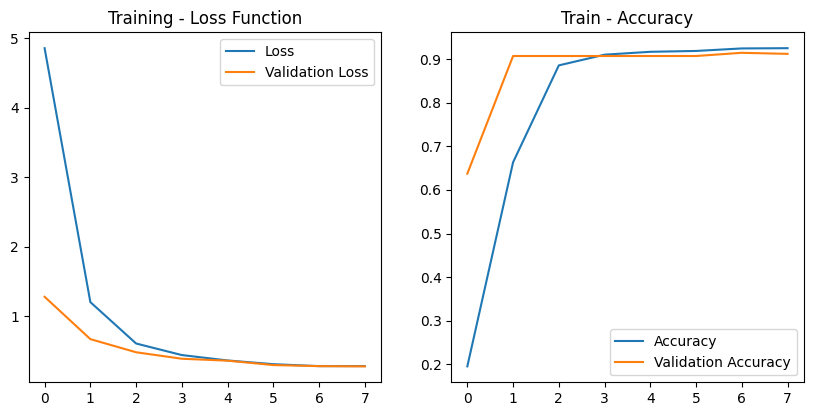

In [23]:
#show plots for our loss function and the accurancy
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [24]:
#print results of our swizzle model metrics
score = swizzle_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2190
Test Accuracy : 0.9279


2023-01-03 15:06:01.439138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [25]:
#swizzle_model.save('cnn_Tabs_of_songs_with_8_epochs.h5')